In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image

In [2]:
model   = tf.keras.models.load_model('./image_classification.h5')
dataDir = './input'

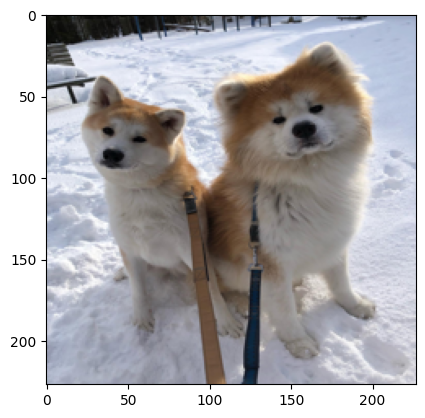

In [21]:
img = Image.open(dataDir + '/0.jpg')
img = img.resize((227,227))
dogImg = Image.open(dataDir + '/dog.jpg').resize((227,227))
plt.imshow(dogImg)
plt.show()

In [23]:
options = {
    0: 'bird',
    1: 'cat',
    2: 'dog'
}

In [24]:
def getResult(arr):
    x = np.argmax(arr[0])
    str = options[x]
    return str

In [27]:
def predictAnimal(img):
    img = np.array(img).astype(np.float64)
    img = img.reshape(-1,227,227,3)
    img /= 255.
    prediction = model.predict(img)
    print(getResult(prediction))

In [28]:
predictAnimal(img)

1/1 [==============================] - 0s 37ms/step
cat


In [29]:
predictAnimal(dogImg)

1/1 [==============================] - 0s 21ms/step
dog
